# Python: Potential Quantiles
In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate local potential quantiles and quantile treatment effects. The estimation is based on the article from [Kallus  et al.](https://arxiv.org/abs/1912.12945)

## Data
We define a data generating process to create synthetic data to compare the estimates to the true effect.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing

from sklearn.ensemble import RandomForestClassifier

The data is generated as a location-scale model with confounding of the treatment $D_i$ and instrument $Z_i$

$$\begin{aligned}
Y_i &= \text{loc}\left(D_i,X_i, X^{(conf)}_i\right) + \text{scale}\left(D_i,X_i, X^{(conf)}_i\right)\cdot\varepsilon_i,\\
D_i &=\bold{1}\{1.5Z_i +0.7X^{(conf)}_i + \eta_i > 0\},
\end{aligned}$$

where $X_i\sim\mathcal{U}[0,1]^{p}$, $X^{(conf)}_i \sim\mathcal{U}[-1,1]$, $Z_i\sim \mathcal{B}(1,1/2)$, $\varepsilon_i \sim \mathcal{N}(0,1)$ and $\eta_i \sim \mathcal{N}(0,1)$.
Further, the location and scale are determined according to the following functions

$$\begin{aligned}
\text{location}(d,x, x^{(conf)}) &:= 0.3d + 4dx_4x_1 - 3x_3 - 2x^{(conf)}\\
\text{scale}(d,x, x^{(conf)}) &:= \sqrt{d/2 + 3dx_1 + 0.4x^{(conf)} + 1}
\end{aligned}$$

In [2]:
def f_loc(D, X, X_conf):
  loc = 0.3*D + 4*D*X[:, 4]*2*X[:, 1] - 3*X[:, 3] - 2*X_conf[:, 0]
  return loc

def f_scale(D, X, X_conf):
  scale = np.sqrt(0.5*D + 3*D*X[:, 1] + 0.4*X_conf[:, 0] + 1)
  return scale

def generate_treatment(Z, X, X_conf):
    eta = np.random.normal(size=len(Z))
    d = ((1.5*Z + 0.7*X_conf[:, 0] + eta) > 0)*1.0
    return d

def dgp(n=200, p=5):
    X = np.random.uniform(0, 1, size=[n,p])
    X_conf = np.random.uniform(-1, 1, size=[n,1])
    Z = np.random.binomial(1, p=0.5, size=n) #norm.cdf(3*(1 - X[:, 0] - X[:, 3]))
    D = generate_treatment(Z, X, X_conf)
    epsilon = np.random.normal(size=n)

    Y = f_loc(D, X, X_conf) + f_scale(D, X, X_conf)*epsilon

    return Y, X, D, Z

We can calculate the true potential quantile analytically or through simulations. Here, we will just simulate the true quantile for a range of quantiles.

In [3]:
tau_vec = np.arange(0.2,0.9,0.1)
p = 5
n_true = int(10e+6)

In [4]:
X_true = np.random.uniform(0, 1, size=[n_true,p])
X_conf_true = np.random.uniform(-1, 1, size=[n_true,1])
Z_true = np.random.binomial(1, p=0.5, size=n_true) #norm.cdf(3*(1 - X[:, 0] - X[:, 3]))
eta_true = np.random.normal(size=n_true)
D1_true = generate_treatment(np.ones_like(Z_true), X_true, X_conf_true)
D0_true = generate_treatment(np.zeros_like(Z_true), X_true, X_conf_true)
epsilon_true = np.random.normal(size=n_true)

compliers = (D1_true == 1) * (D0_true == 0)
print(f'Compliance probability: {str(compliers.mean())}')
n_compliers = compliers.sum()
Y1 = f_loc(np.ones(n_compliers), X_true[compliers, :], X_conf_true[compliers, :]) + f_scale(np.ones(n_compliers), X_true[compliers, :], X_conf_true[compliers, :])*epsilon_true[compliers]
Y0 = f_loc(np.zeros(n_compliers), X_true[compliers, :], X_conf_true[compliers, :]) + f_scale(np.zeros(n_compliers), X_true[compliers, :], X_conf_true[compliers, :])*epsilon_true[compliers]

Compliance probability: 0.4503059


In [5]:
Y0_quant = np.quantile(Y0, q=tau_vec)
Y1_quant = np.quantile(Y1, q=tau_vec)

print(f'Local Potential Quantile Y(0): {Y0_quant}')
print(f'Local Potential Quantile Y(1): {Y1_quant}')

Local Potential Quantile Y(0): [-2.66498857 -2.07641564 -1.58478181 -1.13486311 -0.69702074 -0.24160949
  0.27343877]
Local Potential Quantile Y(1): [-1.28636912 -0.47657298  0.2319042   0.91443294  1.62012926  2.41389391
  3.39502843]


Let us generate $n=500$ observations and convert them to a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html) object.

In [6]:
n = 5000
p = 5
Y, X, D, Z = dgp(n=n,p=p)
obj_dml_data = dml.DoubleMLData.from_arrays(X, Y, D, Z)

## Local Potential Quantiles (LPQs)
Next, we can initialize our two machine learning algorithms to train the different classifiers. Then we can initialize the `DoubleMLPQ` objects and call `.fit()` to estimate the relevant parameters. To obtain confidence intervals, we can use the `.confint()` method.

In [7]:
ml_m = RandomForestClassifier(n_estimators=100)

n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")

LPQ_0 = np.full((len(tau_vec)), np.nan)
LPQ_1 = np.full((len(tau_vec)), np.nan)

ci_LPQ_0 = np.full((len(tau_vec),2), np.nan)
ci_LPQ_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    print(f'Quantile: {tau}')
    dml_LPQ_0 = dml.DoubleMLLPQ(obj_dml_data, ml_m,
                                score="LPQ",
                                treatment=0,
                                quantile=tau,
                                n_folds=5,
                                trimming_threshold=0.05)
    dml_LPQ_1 = dml.DoubleMLLPQ(obj_dml_data,ml_m,
                                score="LPQ",
                                treatment=1,
                                quantile=tau,
                                n_folds=5,
                                trimming_threshold=0.05)

    dml_LPQ_0.fit(n_jobs_cv=n_cores-1)
    dml_LPQ_1.fit(n_jobs_cv=n_cores-1)

    LPQ_0[idx_tau] = dml_LPQ_0.coef
    LPQ_1[idx_tau] = dml_LPQ_1.coef

    ci_LPQ_0[idx_tau, :] = dml_LPQ_0.confint(level=0.95).to_numpy()
    ci_LPQ_1[idx_tau, :] = dml_LPQ_1.confint(level=0.95).to_numpy()

Number of Cores: 8
Quantile: 0.2
Quantile: 0.30000000000000004
Quantile: 0.4000000000000001
Quantile: 0.5000000000000001
Quantile: 0.6000000000000001
Quantile: 0.7000000000000002
Quantile: 0.8000000000000003


Finally, let us take a look at the estimated quantiles.

In [8]:
data = {"Quantile": tau_vec, "Y(0)": Y0_quant, "Y(1)": Y1_quant,
        "DML Y(0)": LPQ_0, "DML Y(1)": LPQ_1,
        "DML Y(0) lower": ci_LPQ_0[:, 0], "DML Y(0) upper": ci_LPQ_0[:, 1],
        "DML Y(1) lower": ci_LPQ_1[:, 0], "DML Y(1) upper": ci_LPQ_1[:, 1]}
df = pd.DataFrame(data)
print(df)

   Quantile      Y(0)      Y(1)  DML Y(0)  DML Y(1)  DML Y(0) lower  \
0       0.2 -2.664989 -1.286369 -2.742056 -1.443484       -2.927260   
1       0.3 -2.076416 -0.476573 -2.050484 -0.794857       -2.291876   
2       0.4 -1.584782  0.231904 -1.523844 -0.251479       -1.737259   
3       0.5 -1.134863  0.914433 -1.101170  0.366721       -1.329960   
4       0.6 -0.697021  1.620129 -0.755475  1.296595       -0.976835   
5       0.7 -0.241609  2.413894 -0.233262  2.327589       -0.489381   
6       0.8  0.273439  3.395028  0.318725  3.307824       -0.011626   

   DML Y(0) upper  DML Y(1) lower  DML Y(1) upper  
0       -2.556852       -1.836568       -1.050400  
1       -1.809093       -1.119356       -0.470357  
2       -1.310429       -0.687397        0.184440  
3       -0.872380        0.011145        0.722298  
4       -0.534116        0.581587        2.011604  
5        0.022858        1.569136        3.086042  
6        0.649075        2.573997        4.041652  


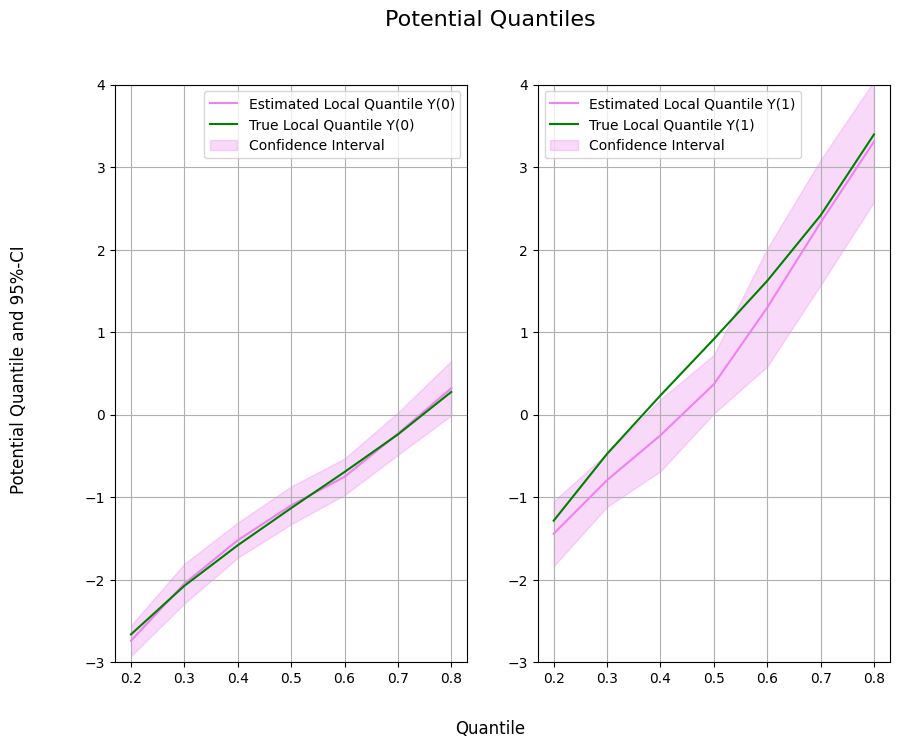

In [9]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)
ax1.grid(); ax2.grid()

ax1.plot(df['Quantile'],df['DML Y(0)'], color='violet', label='Estimated Local Quantile Y(0)')
ax1.plot(df['Quantile'],df['Y(0)'], color='green', label='True Local Quantile Y(0)')
ax1.fill_between(df['Quantile'], df['DML Y(0) lower'], df['DML Y(0) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_ylim(-3, 4)

ax2.plot(df['Quantile'],df['DML Y(1)'], color='violet', label='Estimated Local Quantile Y(1)')
ax2.plot(df['Quantile'],df['Y(1)'], color='green', label='True Local Quantile Y(1)')
ax2.fill_between(df['Quantile'], df['DML Y(1) lower'], df['DML Y(1) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_ylim(-3, 4)

fig.suptitle('Potential Quantiles', fontsize=16)
fig.supxlabel('Quantile')
_ = fig.supylabel('Potential Quantile and 95%-CI')

## Local Quantile Treatment Effects (LQTEs)
In most cases, we want to evaluate the quantile treatment effect as the difference between potential quantiles.
To estimate the quantile treatment effect, we can use

In [10]:
dml_LQTE = dml.DoubleMLQTE(obj_dml_data, ml_g=ml_m, quantiles=tau_vec, n_rep=1,
                           score='LPQ', n_folds=5)
dml_LQTE.fit(n_jobs_cv=n_cores-1)
LQTE_est = dml_LQTE.coef
print(dml_LQTE)

================== DoubleMLQTE Object ==================

------------------ Fit summary       ------------------
         coef   std err          t         P>|t|     2.5 %    97.5 %
0.2  1.268060  0.205071   6.183531  6.268357e-10  0.866129  1.669991
0.3  1.205992  0.187372   6.436363  1.223702e-10  0.838750  1.573233
0.4  1.300600  0.214279   6.069646  1.281925e-09  0.880620  1.720581
0.5  1.424531  0.177693   8.016811  1.085256e-15  1.076259  1.772803
0.6  1.837132  0.401932   4.570757  4.859646e-06  1.049360  2.624903
0.7  2.489592  0.324064   7.682411  1.561218e-14  1.854438  3.124745
0.8  2.917465  0.279312  10.445192  1.541436e-25  2.370024  3.464905


As for other ``dml`` objects, we can use ``.bootstrap`` and ``.confint`` to generate jointly valid confidence intervals.

In [11]:
dml_LQTE.bootstrap(n_rep_boot=2000)
ci_LQTE = dml_LQTE.confint(level=0.95, joint=True)
ci_LQTE

,2.5 %,97.5 %
0.2,0.739890,1.796230
0.3,0.723406,1.688577
0.4,0.748713,1.852488
0.5,0.966874,1.882189
0.6,0.801936,2.872327
0.7,1.654948,3.324235
0.8,2.198083,3.636846


As before, let us take a look at the estimated effects and confidence intervals.

In [12]:
LQTE = Y1_quant - Y0_quant
data = {"Quantile": tau_vec, "LQTE": LQTE, "DML LQTE": LQTE_est,
        "DML LQTE lower": ci_LQTE['2.5 %'], "DML LQTE upper": ci_LQTE['97.5 %']}
df = pd.DataFrame(data)
print(df)

     Quantile      LQTE  DML LQTE  DML LQTE lower  DML LQTE upper
0.2       0.2  1.378619  1.268060        0.739890        1.796230
0.3       0.3  1.599843  1.205992        0.723406        1.688577
0.4       0.4  1.816686  1.300600        0.748713        1.852488
0.5       0.5  2.049296  1.424531        0.966874        1.882189
0.6       0.6  2.317150  1.837132        0.801936        2.872327
0.7       0.7  2.655503  2.489592        1.654948        3.324235
0.8       0.8  3.121590  2.917465        2.198083        3.636846


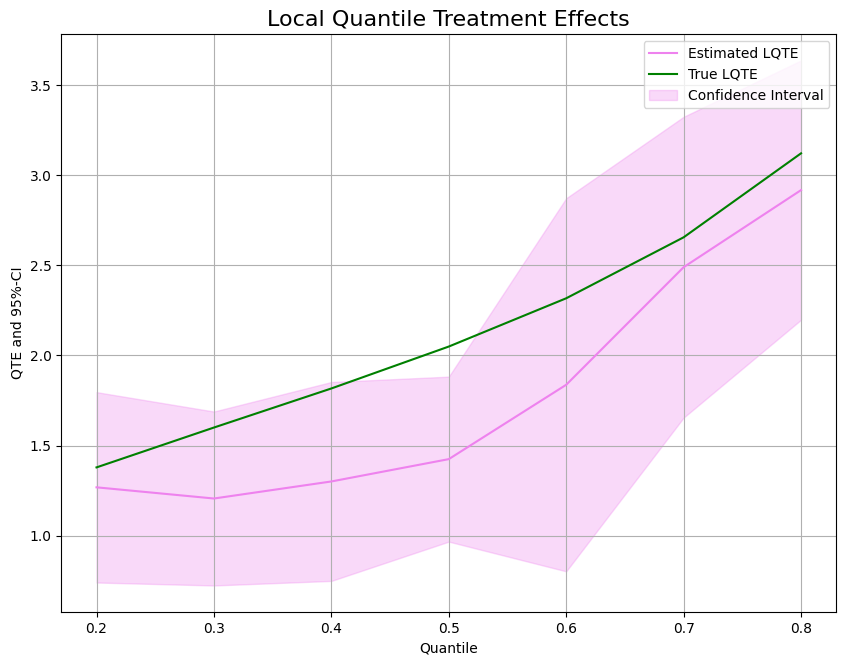

In [13]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid()

ax.plot(df['Quantile'],df['DML LQTE'], color='violet', label='Estimated LQTE')
ax.plot(df['Quantile'],df['LQTE'], color='green', label='True LQTE')
ax.fill_between(df['Quantile'], df['DML LQTE lower'], df['DML LQTE upper'], color='violet', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('Local Quantile Treatment Effects', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('QTE and 95%-CI')